# Prediction of sea ice extent over the Arctic

In this notebook we:

- retrieve gridded time series of: the NAO index, the AO index, the NINO index, CO2 concentration, and sea ice concentration;
- select an area including the Barents and Kara seas for our analysis;
- sum up all sea ice concentration in that area (~ total area over which there is sea ice);
- fit a Gaussian process over this as function of time;
- analyse results.

## 1. Retrieve and visualise data 

In [2]:
%matplotlib notebook

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import tensorflow as tf
import gpflow 
from gpflow.kernels import RBF, Periodic, RationalQuadratic, White

### Download datasets

Timeseries:

- all available from github: https://github.com/scott-hosking/notebooks/tree/master/sea_ice_data

Or download separately: 

- nao: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table
- nino: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
- ao: https://www.esrl.noaa.gov/psd/data/correlation/ao.data
- co2: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

Gridded Arctic sea ice concentration (SIC) data. Values range between 0 and 100, with land points represented by -1

- Full dataset (zip, 263MB): ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
- Sub-region (nc): https://github.com/scott-hosking/notebooks/blob/master/sea_ice_data/sic_subregion.nc?raw=true

In [3]:
def reshape_col_month(df, col_name):
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values:
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    # new[col_name] = np.array(df.drop(columns='Year')).flatten()
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [4]:
def draw_area(dat):
    plt.figure()
    ax = plt.subplot(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,60,90], ccrs.PlateCarree())
    dat.isel(time=0).plot.contourf('longitude', 'latitude',ax=ax,
    levels=range(0, 100,5),cmap='Blues_r',transform=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()
    ax.set_title('Sea ice concentration for a small area',size='xx-large')
    plt.show()

In [97]:
def plot_all(dates, X, Y):
    plt.figure()
    #plt.plot(dates,X[:,1],label='NAO')
    #plt.plot(dates,X[:,2],label='NINO')
    #plt.plot(dates,X[:,3],label='AO')
    co2_mean = X[:,4]-np.mean(X[:,4])
    co2 = co2_mean/max(co2_mean)
    plt.plot(dates,co2,label='CO2')
    y_mean = Y - np.mean(Y)
    y = y_mean/max(y_mean)
    plt.plot(dates,y,label='Total sea ice')
    plt.legend()
    plt.show()

Load weather data: 

In [99]:
url = 'sea_ice_data/norm.nao.monthly.b5001.current.ascii.table'
nao = pd.read_csv(url, delim_whitespace=True, header=None)
nao.rename(columns = {0: 'Year'}, inplace=True)
nao = reshape_col_month(nao, 'NAO')
nao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nao.iterrows() ]
nao['time'] = pd.DatetimeIndex(dt)
nao = nao.drop(columns=['Day'])

url = 'sea_ice_data/nino34.long.anom.data'
nino = pd.read_csv(url, skiprows=1, skipfooter=7, delim_whitespace=True, header=None)
nino.rename(columns = {0: 'Year'}, inplace=True)
nino = reshape_col_month(nino, 'NINO')
nino['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nino.iterrows() ]
nino['time'] = pd.DatetimeIndex(dt)
nino = nino.drop(columns=['Day'])

url = 'sea_ice_data/ao.data'
ao = pd.read_csv(url, skiprows=1, skipfooter=3, delim_whitespace=True, header=None)
ao.rename(columns = {0: 'Year'}, inplace=True)
ao = reshape_col_month(ao, 'AO')
ao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in ao.iterrows() ]
ao['time'] = pd.DatetimeIndex(dt)

url = 'sea_ice_data/co2_mm_mlo.txt'
co2 = pd.read_csv(url, skiprows=72, delim_whitespace=True, usecols=[0,1,3], names=['Year','Month','CO2'])
co2['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in co2.iterrows() ]
co2['time'] = pd.DatetimeIndex(dt)

# Merge time series
df = pd.merge(nino,nao)
df = pd.merge(df,ao)
df = pd.merge(df,co2)
df = df.drop(columns=['Day'], axis=0)

# Load sea ice data
ds = xr.open_dataset('G10010_SIBT1850_v1.1.nc')
da = ds.seaice_conc
da = da.sel(time=slice('1979-01-01', None)) # take slice over the satellite
# era only (1979-present)

# Select area to work on
da1 = da.isel(latitude=slice(10,95),longitude=slice(65,400))

C:\Users\fruocs\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\fruocs\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


Draw the selected area on the map:

<IPython.core.display.Javascript object>


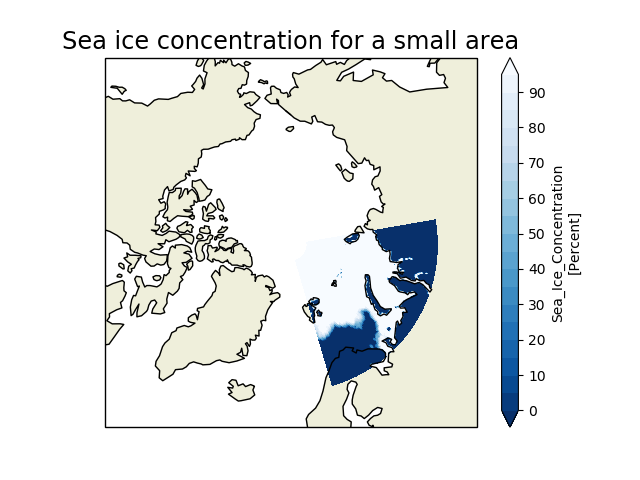

In [100]:
draw_area(da1)

In [121]:
# Sum ice concentration in area selected
dsum = da1.sum(dim=['latitude','longitude'])

# Generate datetime objects for x-axis
df_all = pd.merge(df,dsum.to_dataframe().reset_index())
X = df_all[['Month','NAO','NINO','AO','CO2']].values
Y = dsum.values
yrs = df_all['Year'].values
dates = np.array([datetime.date(yrs[i],int(X[i,0]),15) for i in range(len(
    yrs))])

Plot the CO2 and sea ice extent data as functions of time:

<IPython.core.display.Javascript object>


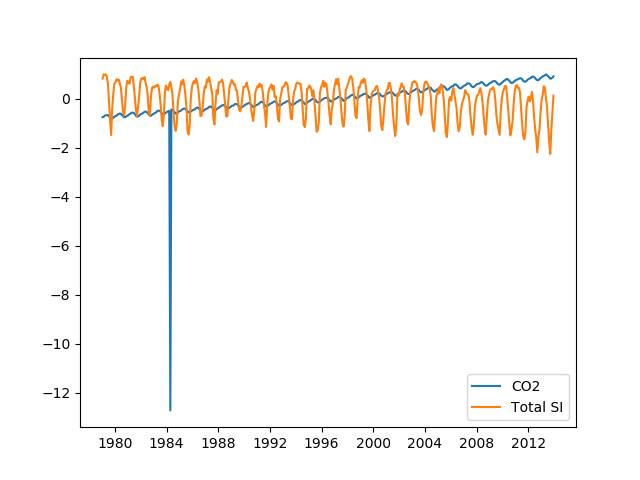

In [122]:
plot_all(dates,X,Y)

The -99.9 signals a missing data point; remove it.

<IPython.core.display.Javascript object>


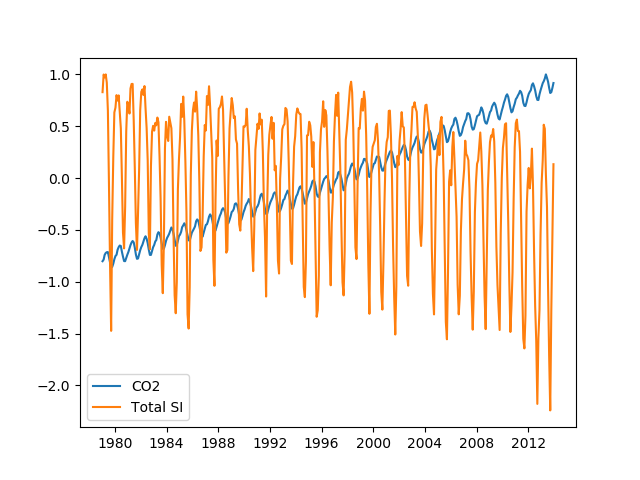

In [123]:
X = np.delete(X,np.where(yrs==1984)[0][3],0)
Y = np.delete(Y,np.where(yrs==1984)[0][3])
yrs = np.delete(yrs,np.where(yrs==1984)[0][3])
dates = np.array([datetime.date(yrs[i],int(X[i,0]),15) for i in range(len(
    yrs))])
plot_all(dates,X,Y)

## Predicition of sea ice extent in an area (over Barents-Kara seas)

### 1. Naive time series

In this first attempt, we shall fit a GP to the sea ice extent as a function of time only. We'll be using a kernel of the form discussed in Rasmussen (2006), Ch 5.4.3 "Mauna Loa CO2".

The training/testing set split is at 2010.

C:\Users\fruocs\anaconda\envs\test\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


<IPython.core.display.Javascript object>


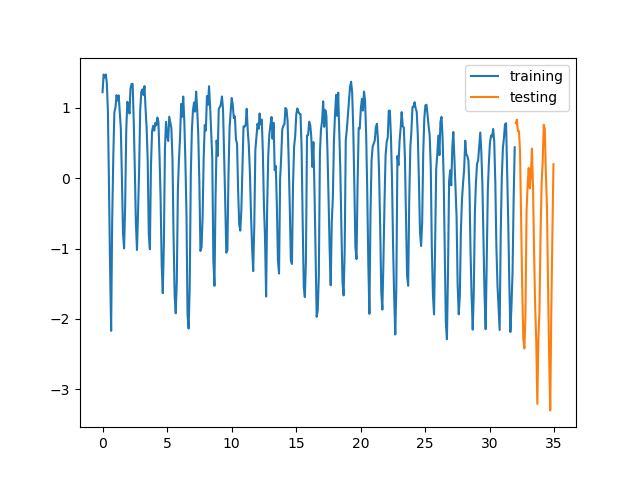

In [163]:
# Split data into training and testing datasets
train_ind, test_ind = np.where(yrs <= 2010)[0], np.where(yrs > 2010)[0]
Y_scaled = preprocessing.scale(Y)
X_train, X_test, Y_train, Y_test = ts[train_ind], ts[test_ind],\
                                    Y_scaled[train_ind], Y_scaled[test_ind]

plt.figure()
plt.plot(X_train, Y_train,label='training')
plt.plot(X_test, Y_test,label='testing')
plt.legend()
plt.show()

In [345]:
# Design kernel

k1 = RBF(input_dim=1,lengthscales=32,variance=0.5**2)
k2 = RBF(input_dim=1,lengthscales=100,variance=1)*Periodic(input_dim=1,period=1,lengthscales=1.2)
k3 = RationalQuadratic(input_dim=1,alpha=100,lengthscales=10.,variance=0.5**2)
k4 = RBF(input_dim=1,lengthscales=0.2,variance=0.01**2) + White(input_dim=1,variance=1e-5)
kernel = k1+k2+k3+k4

In [346]:
kernel

,class,prior,transform,trainable,shape,fixed_shape,value
Sum/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,32.0
Sum/kernels/0/variance,Parameter,None,+ve,True,(),True,0.25
Sum/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,100.0
Sum/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1.2
Sum/kernels/1/kernels/1/period,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/2/alpha,Parameter,None,+ve,True,(),True,100.0
Sum/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,10.0
Sum/kernels/2/variance,Parameter,None,+ve,True,(),True,0.25


In [347]:
model = gpflow.models.GPR(X_train.reshape(-1,1).astype('float64'),
                         Y_train.reshape(-1,1).astype('float64'),
                         kernel)
gpflow.train.ScipyOptimizer().minimize(model,disp=True)

In [348]:
X_all = ts.reshape(-1,1)
Y_pred_mean, Y_pred_var = model.predict_y(X_all)

<IPython.core.display.Javascript object>


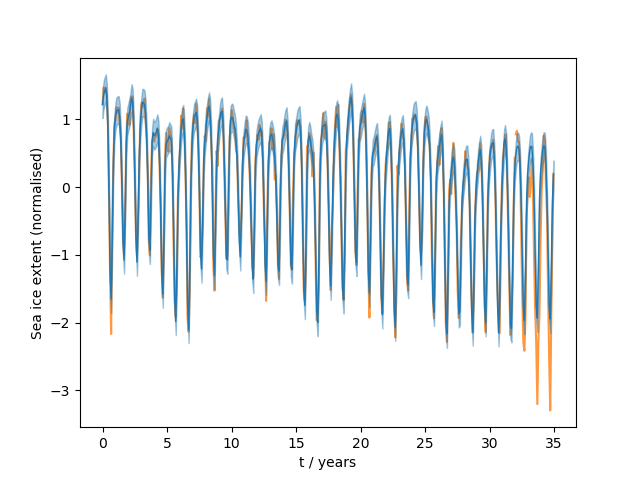

In [349]:
plt.figure()
plt.plot(X_all, Y_pred_mean, lw=1,color='C0',zorder=9)
plt.fill_between(X_all.flatten(), (Y_pred_mean - np.sqrt(np.diag(Y_pred_var))).flatten(),
                 (Y_pred_mean + np.sqrt(np.diag(Y_pred_var))).flatten(),
                 alpha=0.4,color='C0',zorder=9)
plt.plot(X_train, Y_train,color='C1',alpha=0.8)
plt.plot(X_test, Y_test,color='C1',alpha=0.8)
plt.xlabel('t / years')
plt.ylabel('Sea ice extent (normalised)')
plt.show()

In [350]:
kernel

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,32.46921367467851
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,0.2985234219551528
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,102.21803745242359
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,0.9642016983621349
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.5652439070700019
GPR/kern/kernels/1/kernels/1/period,Parameter,None,+ve,True,(),True,1.000706977157304
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,0.964201698263581
GPR/kern/kernels/2/alpha,Parameter,None,+ve,True,(),True,99.99830294908104
GPR/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,1.2354427728703272
GPR/kern/kernels/2/variance,Parameter,None,+ve,True,(),True,0.04076584481631028


### 2. Draw each component of this naive model

Draw each member of the GP:

<IPython.core.display.Javascript object>


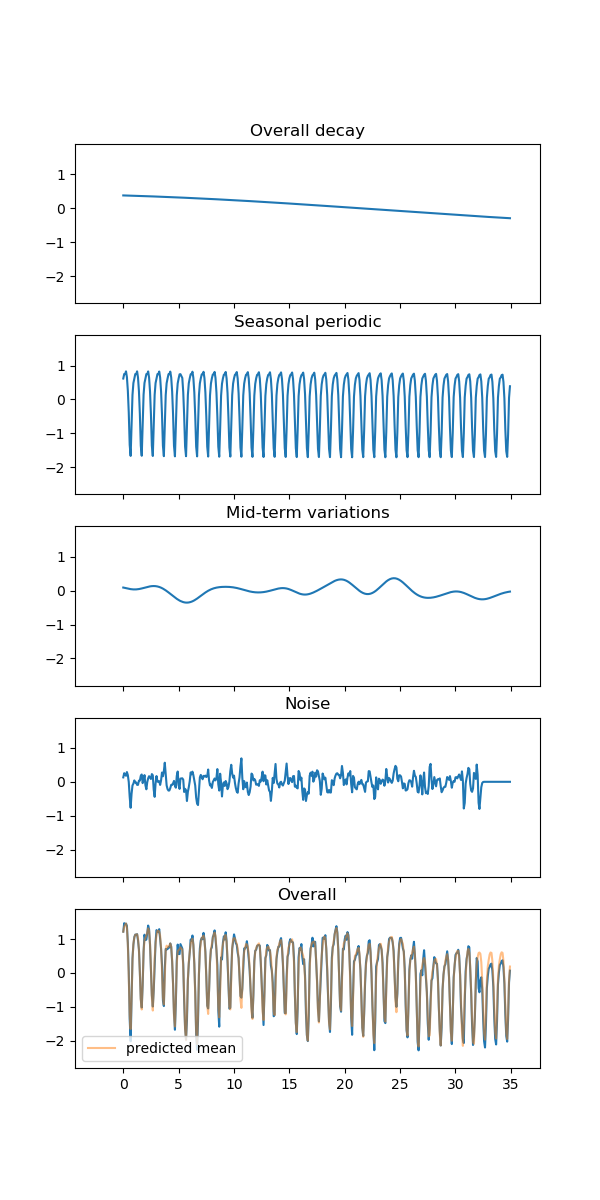

In [416]:
def plot_kernel_component(ksum, k, xs, x, y, ax, title):
    xs = xs.reshape(-1,1)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    ksumxx = ksum.compute_K_symm(x)
    ksx = k.compute_K(xs,x)
    mean = ksx@np.linalg.inv(ksumxx)@y
    ax.plot(xs,mean)
    ax.set_title(title)

f, axes = plt.subplots(5, 1, figsize=(6,12),sharex=True, sharey=True)
for i,k,title in zip(range(5),[k1,k2,k3,k4],['Overall decay', 'Seasonal periodic', 'Medium-term variations', 'Noise']):
    plot_kernel_component(kernel,k,ts,ts[train_ind],Y_scaled[train_ind],axes[i],title)
plot_kernel_component(kernel,k1+k2+k3+k4,ts,ts[train_ind],Y_scaled[train_ind],axes[4],'Overall')
axes[4].plot(ts,Y_pred_mean,label='predicted mean',alpha=0.5)
axes[4].legend()
plt.show()

The large contribution of the noise component to the learnt kernel suggests that the model does not describe the data well. 

What could be done to improve this model?

- Add features?
- Change kernel?
- Use something else for regression other than GPs?